# Clustering con el Metodo StreamKmeans y DbStream en arduino

In [1]:
#importar librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import arff
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

import math
import serial
import struct
import time
from IPython.display import clear_output


from scipy.spatial.distance import cdist


import random

from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from IPython.display import display, Markdown, HTML, clear_output

%matplotlib inline

In [2]:
#printPoints(X, Y):
def printPoints(X, Y, nameOfDataset, withCentroids = False, centroids = []):
    plt.title('training set')
    numClass = len(np.unique(Y))
    for currentIndexClass in range(numClass):
        currentClass = np.unique(Y)[currentIndexClass]
        if(withCentroids):
            plt.plot(X[Y==currentClass,0], X[Y==currentClass,1], '.', label=("class " + str(currentClass)), alpha=0.5)
        else:
            #plt.plot(X[Y==currentClass,0], X[Y==currentClass,1], '.', label=("class " + str(currentClass)))
            plt.plot(X[Y==currentClass,0], X[Y==currentClass,1], '.')
        

    plt.plot(X[Y==-1,0], X[Y==-1,1], '.', label=("noise"), alpha=0.5, color='black') 



    if( withCentroids ):
        for currentCentroid in range(numClass):
            plt.scatter(centroids[currentCentroid, 0], centroids[currentCentroid, 1], color='black')

    plt.title(nameOfDataset)
    #plt.legend()
    plt.show()
    

In [3]:
#distEuclid( point1, point2 ):
def distEuclid( point1, point2 ):
    dist = 0
    for i in range(point1.size):
        dist = dist + (point1[i] - point2[i]) * (point1[i] - point2[i])
  
    dist = math.sqrt(dist)
    return dist

In [15]:
#streamKmeansArduino( X, numKlusters, forget, learningR, numDimensions ):

def setUpStreamKeans(numKlusters, forget, learningR, numDimensions, currentSerial):
    # first message to arduino is used to set the hyperparameters of the hardware
    data = str(numKlusters) + "\n"
    currentSerial.write(data.encode())
    data = str(forget) + "\n"
    currentSerial.write(data.encode())
    data = str(learningR) + "\n"
    currentSerial.write(data.encode())
    data = str(numDimensions) + "\n"
    currentSerial.write(data.encode())

def writePoint(PointToWrite, currentSerial):

    #send point to arduino trought serial
    lenghtPoint = len(PointToWrite)
    for indexPoint in range(lenghtPoint):
        data= PointToWrite[indexPoint]
        data = str(data) + "\n"
        currentSerial.write(data.encode())


def readCentroidFromSerial(currentSerial, numDimensions):
    # reads value of centroid from the arduino trhought serial
    newCentroid = np.zeros(numDimensions)
    for dimensionIndex in range(numDimensions):
        newCentroidValue = ''
        while newCentroidValue == '':
            newCentroidValue = currentSerial.readline().decode('utf-8')
            newCentroid[dimensionIndex]=float(newCentroidValue)
    return newCentroid

def streamKmeansArduino( X, numKlusters, forget, learningR, numDimensions ):
    #set up the arduino
    ser = serial.Serial('COM3', 9600, timeout=1)
    setUpStreamKeans(numKlusters, forget, learningR, numDimensions, ser)

    #set up the data
    Y = np.zeros(len(X))
    times = np.zeros(len(X))
    numbers = list(range(len(X)))
    random.shuffle(numbers)

    centroids = np.zeros((numKlusters, numDimensions))
    currentPoint = 0

    #run the algorithm
    while currentPoint < len(X):

        writePoint(X[numbers[currentPoint]], ser)

        newY = ''
        while newY == '':
            newY = ser.readline().decode('utf-8')
        Y[currentPoint]=int(newY)

        centroids[int(newY)] = readCentroidFromSerial(ser, numDimensions)
        
        newTime = ''
        while newTime == '':
            newTime = ser.readline().decode('utf-8')
        times[currentPoint]=int(newTime)

        currentPoint = currentPoint + 1

    #return solution
    return Y, centroids, np.mean(times)


In [5]:
#dbStreamArduino( X, minNeighboors, minDistance, numDimensions, elementsStored ):

def setUpDbStream(minNeighboors, minDistance, numDimensions, currentSerial):
    # first message to arduino is used to set the hyperparameters of the hardware
    data = str(minNeighboors) + "\n"
    currentSerial.write(data.encode())
    data = str(minDistance) + "\n"
    currentSerial.write(data.encode())
    data = str(numDimensions) + "\n"
    currentSerial.write(data.encode())


def writePoint(PointToWrite, currentSerial):

    #send point to arduino trought serial
    lenghtPoint = len(PointToWrite)
    for indexPoint in range(lenghtPoint):
        data= PointToWrite[indexPoint]
        data = str(data) + "\n"
        currentSerial.write(data.encode())


def readPoints(currentSerial, X, numDim, elementsStored ):

    for point in range(elementsStored):

        for currDim in range(numDim):
            output = ''
            while( output == '' ):
                output = currentSerial.readline().decode('utf-8')
            
            X[point][currDim] = float(output)


def readLabels(currentSerial, Y, elementsStored):

    for point in range(elementsStored):

        output = ''
        while( output == '' ):
            output = currentSerial.readline().decode('utf-8')
            
        Y[point] = float(output)
    
    


def readDataOfDbStream(currentSerial, numDimensions, elementsStored):
    
    X = np.zeros((elementsStored, numDimensions))
    Y = np.zeros(elementsStored)

    readPoints(currentSerial, X, numDimensions, elementsStored )

    output = ''
    while( output == '' ):
        output = currentSerial.readline().decode('utf-8')
    
    readLabels(currentSerial, Y, elementsStored)

    return X, Y


def dbStreamArduino( X, minNeighboors, minDistance, numDimensions, elementsStored ):
    #set up the arduino
    ser = serial.Serial('COM3', 9600, timeout=1)
    setUpDbStream(minNeighboors, minDistance, numDimensions, ser)

    #set up the data
    numbers = list(range(len(X)))
    random.shuffle(numbers)
    currentPoint = 0

    #run the algorithm
    while currentPoint < len(X):
        writePoint(X[numbers[currentPoint]], ser)
        output = ''
        while output == '':
            output = ser.readline().decode('utf-8')
        
        #clear_output(wait=False)
        #print( str(currentPoint) + " / " + str(len(X)))
        currentPoint = currentPoint + 1

    flagPoint = np.zeros(numDimensions)
    flagPoint[0] = -60
    writePoint(flagPoint, ser)
    
    #return solution
    return readDataOfDbStream(ser, numDimensions, elementsStored)


In [6]:
#loadData(dataFileDir)

def loadData(dataFileDir):

  data, meta = arff.loadarff(dataFileDir)
  X = []
  Y = []

  for num in data:
    #print(num[len(num)-1])
    nextNumY = int(num[len(num)-1])
    Y.append(nextNumY)
    nextValue = []
    for numDim in num:
      nextValue.append(numDim)
    nextValue.pop(len(nextValue)-1)
    X.append(nextValue)
    #nextValuePlusY = nextValue.append(nextNumY)
    #XY.append(nextValuePlusY)

  X = np.array(X)
  Y = np.array(Y)
  return( X, Y )


In [7]:
#def getYfromCentroids(X, Centroids):
def getYfromCentroids(X, Centroids):
    Y = np.zeros(len(X))
    for currentPointIndex in range(len(X)):
        currentPoint = X[currentPointIndex]
        minDist = 10000
        chossenCentroid = -1
        for currentCentroidIndex in range(len(Centroids)):
            currentCentroid = Centroids[currentCentroidIndex]
            currentDistance = distEuclid(currentPoint, currentCentroid)
            if( minDist > currentDistance):
                minDist = currentDistance
                chossenCentroid = currentCentroidIndex
        Y[currentPointIndex] = chossenCentroid
    return Y



In [8]:
#def getYfromXCluster(X, Xclusters, Yclusters):
def getYfromXCluster(X, Xclusters, Yclusters):
    Y = np.zeros(len(X))
    for currentPointIndex in range(len(X)):
        currentPoint = X[currentPointIndex]
        minDist = 10000
        chossenCluster = -1
        for xClusterIndex in range(len(Xclusters)):
            pointFromCluster = Xclusters[xClusterIndex]
            currentDistance = distEuclid(currentPoint, pointFromCluster)
            if( minDist > currentDistance):
                minDist = currentDistance
                chossenCluster = Yclusters[xClusterIndex]
        Y[currentPointIndex] = chossenCluster
    return Y


In [9]:
#def getSilhouetteScore(X, Y):
def isTheSamePoint( point1, point2):

    for i in range(point1.size):
        if ( point1[i] != point2[i] ):
            return False

    return True

def calculate_distances(X):
    num_points = len(X)
    distances = np.zeros((num_points, num_points))

    for i in range(num_points):
        for j in range(num_points):
            distances[i, j] = distEuclid(X[i], X[j])

    return distances

def getSilhouetteScore(X, Y):
    num_points = len(X)
    distances = calculate_distances(X)
    silhouette_scores = []

    for i in range(num_points):
        cluster_i_mask = Y == Y[i]
        cluster_i_size = np.sum(cluster_i_mask)
        if cluster_i_size > 1:
            a_i = np.sum(distances[i, cluster_i_mask]) / (cluster_i_size - 1)
        else:
            a_i = 0

        b_i_values = []
        for j in range(num_points):
            if Y[j] != Y[i]:
                b_i_values.append(np.mean(distances[i, Y == Y[j]]))

        b_i_min = min(b_i_values) if b_i_values else 0

        silhouette_denominator = max(a_i, b_i_min)
        if silhouette_denominator != 0:
            silhouette_i = (b_i_min - a_i) / silhouette_denominator
        else:
            silhouette_i = 0
        silhouette_scores.append(silhouette_i)

    return np.mean(silhouette_scores)



In [10]:
#getSilueteRegularKmeans( X, Y, K ):
def getSilueteRegularKmeans( X, Y, K ):
    
    kmeans = KMeans(n_clusters=K, random_state=42)
    cluster_labels = kmeans.fit_predict(X)

    # Calculate silhouette score
    return silhouette_score(X, cluster_labels)


In [11]:
#joinTillKLeft( arr, K)

# Get unique values and sort them
def map_values(arr):
    unique_values = sorted(set(arr))
    
    # Map values to consecutive positive integers
    value_map = {}
    for index, value in enumerate(unique_values):
        mapped_value = index + 1
        value_map[value] = mapped_value
    
    # Map the values in the array
    mapped_array = []
    for value in arr:
        mapped_array.append(value_map[value])
    
    return mapped_array


def joinTillKLeft( arr, k):
    # Label all instances from 0 to size
    labels = np.arange(arr.shape[0])

    # Compute pairwise distances between instances
    distances = cdist(arr, arr)
        
    # Set diagonal elements (instances to themselves) to infinity
    np.fill_diagonal(distances, np.inf)

    while len(np.unique(labels)) > k:
        
        # Find the closest pair of instances with different labels
        min_distance = np.min(distances[np.nonzero(distances)])
        closest_instances = np.where(distances == min_distance)
        distances[distances == min_distance] = np.inf
        instance1, instance2 = closest_instances[0][0], closest_instances[1][0]
        
        # Union the labels of the closest pair
        label1, label2 = labels[instance1], labels[instance2]
        labels[labels == label2] = label1

    labels = map_values(labels) 
    return labels


In [12]:
#trimSmallerClasses( centroids, yCluster, K ):
def trimSmallerClasses( yCluster, K ):

    diferentClass = np.unique(yCluster).copy()
    
    yCluster = np.array(yCluster)
    numElemClass = np.zeros(len(np.unique(yCluster)))

    numClass = len(np.unique(yCluster))
    for currentIndexClass in range(numClass):
        currentClass = np.unique(yCluster)[currentIndexClass]
        numElemClass[currentIndexClass] = np.count_nonzero(yCluster == currentClass)

    
    while len(np.unique(yCluster)) > K + 1:
        indexClassWithLess = np.argmin(numElemClass)
        classWithLess = diferentClass[indexClassWithLess]
        yCluster[np.where(yCluster == classWithLess)[0]] = -1
        numElemClass[indexClassWithLess] = math.inf



    return yCluster


In [ ]:
#test dbstream

#nameOfDataset = "complex8"
#nameOfDataset = "shapes"
nameOfDataset = "square1"


X, Y = loadData("datasets/" + nameOfDataset + ".arff")

minNeighboors = 8
minDistance = 2
numDimensions = 2
elementsStored = 400

t0 = time.time()
Xclusters, Yclusters = dbStreamArduino( X, minNeighboors, minDistance, numDimensions, elementsStored )
t1 = time.time()
totalTime = t1-t0


printPoints(Xclusters, Yclusters, nameOfDataset)


Y = getYfromXCluster(X, Xclusters, Yclusters)
printPoints(X, Y, nameOfDataset)

print("\ntotalTime")
print(totalTime)

print("\nsiluette score")
#print(getSilhouetteScore( X, Y ))

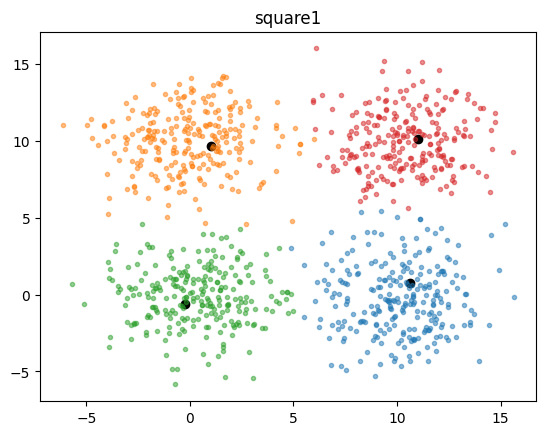


totalTime
3.015019655227661

averageTime
0.013

siluette score
0.593988448815489


In [36]:
#test streamKmeans

#nameOfDataset = "complex8"
#nameOfDataset = "shapes"
nameOfDataset = "square1"
#nameOfDataset = "spiral"
#nameOfDataset = "engytime"


X, Y = loadData("datasets/" + nameOfDataset + ".arff")

numKlusters = 4
forget = 1
learningR = 0.15
numDimensions = 2

t0 = time.time()
Y, centroids, averageTime = streamKmeansArduino( X, numKlusters, forget, learningR, numDimensions )
t1 = time.time()
totalTime = t1-t0


Y = getYfromCentroids(X, centroids)
printPoints(X, Y, nameOfDataset, True, centroids)

#print("\ncentroids")
#print(centroids)

print("\ntotalTime")
print(totalTime)
print("\naverageTime")
print(averageTime)

print("\nsiluette score")
print(getSilhouetteScore( X, Y ))


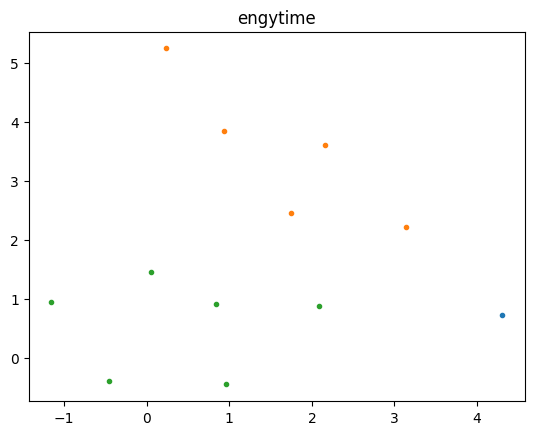

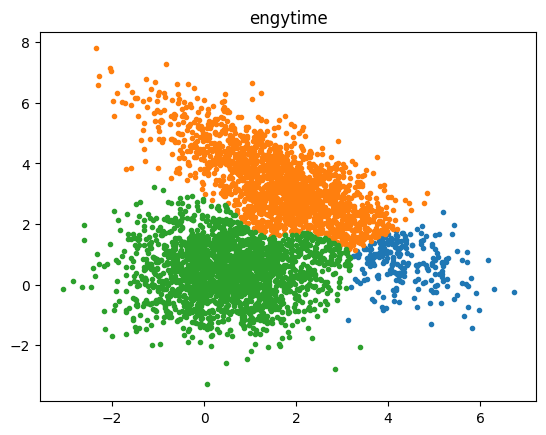

In [39]:
YCluster = joinTillKLeft( centroids, 3 )
printPoints(centroids, YCluster, nameOfDataset)
YClusterRed = trimSmallerClasses( YCluster, 2 )
Yred = getYfromXCluster(X, centroids, YClusterRed)
printPoints( X, Yred, nameOfDataset)


In [95]:

#npYCluster = np.array(YCluster)
#print(npYCluster)
print(np.unique(YCluster))
#np.unique(YCluster)

[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
